# Construct synthetic sequences and look at how the core CTCF motif interacts with the TA motif

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from util import import_peak_table

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import tqdm

import sys
sys.path.append('/home/katie/bp_repo/multitask_profile_model_SPI_GATA/')
from plotting_helper import *
from all_functions import *
from profile_models import ModelLoader
from dinuc_shuffle import dinuc_shuffle

import random
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import pyfaidx

plt.rcParams["figure.dpi"] = 130

### a) Generate a set of 100 random sequence backgrounds

In [2]:
# set seed for reproducibility
rng = np.random.default_rng(2022)

In [3]:
# load in model
assay = 'cutnrun'
tf = 'ctcf'
date = 'jul16'
controls = assay == 'chip-seq'
model = ModelLoader(f'/home/katie/bp_repo/pipeline_outputs/{tf}_{assay}_{date}/' + 'model.state_dict', 
                    controls=controls, num_tasks=1).load_model()

In [4]:
def get_input_seqs(coords_batch):
    """
    For a B x 3 array of coordinates, returns the 2114-length string sequences.
    """
    # Pad everything to the right size
    mid = (coords_batch[:, 1] + coords_batch[:, 2]) // 2
    coords_batch[:, 1] = mid - (input_length // 2)
    coords_batch[:, 2] = coords_batch[:, 1] + input_length

    # Fetch sequences as strings
    reader = pyfaidx.Fasta('/home/katie/bp_repo/multitask_profile_model_SPI_GATA/data/genomes/hg38.fasta')
    seqs = []
    for chrom, start, end in coords_batch:
        seqs.append(reader[chrom][start:end].seq)
    return seqs

In [5]:
tf = tf.upper()
dataloader = DataLoader(tasks=[tf], 
                        assay=assay, controls=controls, tasks_path='/home/katie/bp_repo/research/data/' + assay + '/', subset=['full'])
dataloader = dataloader.make_loaders()['full']

# select 10 random sequence backgrounds from the peak coords
coords_indexes = np.random.choice(list(range(len(dataloader.dataset.coords))), 10)
input_seqs = list(i.upper() for i in get_input_seqs(dataloader.dataset.coords[coords_indexes]))

# get 10 dinucleotide-freq-preserved shuffles per input seq => 100 background seqs total
seqs = []
for i in range(10):
    seqs += dinuc_shuffle(input_seqs[i], 10)

In [70]:
# OLD TOTALLY RANDOM background sequences
seqs = []
alphabet = ['A','C','G','T']

for i in range(100):
    seqs.append(''. join(rng.choice(alphabet) for _ in range(2114)))

### b) Insert the core motif and the TA motif in the center of the sequences, and pass them through the model, averaging the prediction over all 100 sequences

In [6]:
# core_motif = 'TGACGTCA'
core_motif = 'CCACCAGGGGG'
ta_motif = 'TA'

### calculating/plotting functions

In [7]:
def avg_preds_at_distance(distance, seqs, model, core='moving', TA='moving'):
    ''' given a distance between core motif and TA motif, along with 100 random background seqs
        and a model, insert motifs at appropriate distance in each seq, then calculate predictions 
        for each seq, then average predictions across all 100 seqs
        
        update july 2, 2022: 
        new params `core` and `TA` allow you to NOT include the TA motif, and only examine how the profile changes 
        as the core motif moves around as a control; or alternatively to hold the core motif still and move the TA motif 
        valid values:
            `core` in ['moving', 'static']
            `TA` in ['moving', None]
            
        update july 8, 2022:
            now also returns TA binding profile strength if TA == 'moving'
    '''
    core_insertion_index = 2114 // 2 - 10 - distance // 2 #  - 10 can change to something else
    ta_insertion_index = core_insertion_index + len(core_motif) + distance
    
    original_seqs = seqs.copy()  # just to be careful with memory and overriding stuff
    # insert motifs 
    for i in range(len(original_seqs)):
        seq = original_seqs[i]
        assert seq.count(core_motif) < 5
        if core == 'moving' and TA == 'moving':
            original_seqs[i] = seq[:core_insertion_index] + core_motif + seq[core_insertion_index + len(core_motif):ta_insertion_index] + \
            ta_motif + seq[ta_insertion_index + len(ta_motif):]
        elif core == 'moving' and TA == None:
            original_seqs[i] = seq[:core_insertion_index] + core_motif + seq[core_insertion_index + len(core_motif):]  # only insert core motif
        elif core == 'static' and TA == 'moving':
            core_insertion_index = 2114 // 2 - 10
            original_seqs[i] = seq[:core_insertion_index] + core_motif + seq[core_insertion_index + len(core_motif):ta_insertion_index] + \
            ta_motif + seq[ta_insertion_index + len(ta_motif):]
        else:
            print('error in `core` and `TA` parameters')
            return

    original_seqs = dna_to_one_hot(original_seqs)   # so you end up with one-hot encoded seqs
    original_seqs = torch.from_numpy(original_seqs).float()
    original_seqs = original_seqs.cuda(device=device, non_blocking=True)
    
    # get predictions
    with torch.no_grad():
        if controls:
            cont_profs = torch.zeros((100, 1, 1000, 2)).cuda()  # CHANGE THIS IF MORE THAN 1 TASK, other issues etc.
            logit_pred_profs, log_pred_counts = model(original_seqs, cont_profs)
        else:
            logit_pred_profs, log_pred_counts = model(original_seqs)
    logit_pred_profs = logit_pred_profs.detach().cpu().numpy()  # go back to cpu
    log_pred_counts = log_pred_counts.detach().cpu().numpy()
    log_pred_profs = profile_logits_to_log_probs(logit_pred_profs)
    
    # average across all 100 seqs; THESE ARE ALREADY EXPONENTIATED, NO LOG!! also removes the 1st dimension!!
    avg_pred_profs = np.mean(np.exp(log_pred_profs), axis=0) 
    avg_pred_counts = np.mean(np.exp(log_pred_counts), axis=0) 
    
    log_pred_counts_reshaped = np.repeat(log_pred_counts[:, :, np.newaxis, :], 1000, axis=2)  # same shape as log_pred_profs now
    avg_pred_profs_times_counts = np.mean(np.exp(log_pred_profs) * np.exp(log_pred_counts_reshaped), axis=0) 

    TA_binding_strength = None
    if TA == 'moving':
        TA_binding_strength = np.sum(avg_pred_profs_times_counts[0][ta_insertion_index - (2114//2-500) - 3 : ta_insertion_index - (2114//2-500) + 3],
                                     axis=0)
            
    return avg_pred_profs_times_counts, TA_binding_strength

In [7]:
# def plot_TA_binding_strength(TA_binding_strengths):
#     ''' TA_binding_strengths is a list of length 100 from running avg_preds_at_distance over 100 distances (100 times) ''' 
#     # plot TA binding strength at each distance from core motif
#     plt.plot(list(range(0,1000,10)), list(i[0] for i in TA_binding_strengths), color='royalblue',label='Positive strand')
#     plt.plot(list(range(0,1000,10)), list(i[1] for i in TA_binding_strengths), color='goldenrod',label='Negative strand') 
#     plt.xlabel('Distance between core and TA motifs')
#     plt.ylabel('Sum of pred prof * pred counts\nfor 6 bases around TA motif')
#     plt.title('TA binding strength at various distances from core motif')
#     plt.legend()
#     plt.show()
    
def plot_TA_binding_strength(TA_binding_strengths):
    ''' TA_binding_strengths is a list of length 100 from running avg_preds_at_distance over 100 distances (100 times) ''' 
    # plot TA binding strength at each distance from core motif
    plt.plot(list(range(10,490,10)), list(np.mean((i[0], i[1])) for i in TA_binding_strengths[1:-1]), color='royalblue')
    plt.xlabel('Distance between core and TA motifs')
    plt.ylabel('Sum of pred prof * pred counts\nfor 6 bases around TA motif')
    plt.title('TA binding strength at various distances from core motif')
    plt.legend()
    plt.show() 
    
def plot_TA_binding_strength_with_controls(TA_binding_strengths, TA_binding_strength_controls):
    ''' both inputs are a list of TUPLES of length 100 from running avg_preds_at_distance over 100 distances (100 times) 
        plots TA binding strength averaged over both strands; omits sus edges ''' 
    # plot TA binding strength at each distance from core motif

    plt.plot(list(range(10,990,10)), list(np.mean((i[0], i[1])) for i in TA_binding_strengths[1:-1]), 
             color='royalblue',label='Core and TA motifs moving')
    
    plt.plot(list(range(5,495,5)), list(np.mean((i[0], i[1])) for i in TA_binding_strength_controls[1:-1]), 
             color="tomato", alpha=0.7, label='Core in middle, TA motif moving')
            
    plt.xlabel('Distance between core and TA motifs')
    plt.ylabel('Sum of pred prof * pred counts\nfor 6 bases around TA motif')
    plt.title('TA binding strength at various distances from core motif')
    plt.legend()
    plt.show()

### c) Vary the distance between the CTCF motif and the TA motif. How does the profile shape change as the distance changes (show animation)?

In [11]:
all_avg_pred_profs_times_counts, TA_binding_strengths = [], []
for distance in range(0,1000,10):
    avg_pred_profs_times_counts, TA_binding_strength = avg_preds_at_distance(distance, seqs, model)
    all_avg_pred_profs_times_counts.append(avg_pred_profs_times_counts)
    TA_binding_strengths.append(TA_binding_strength)

In [12]:
all_avg_pred_profs_times_counts_control, TA_binding_strength_controls = [], []
for distance in range(0,1000,10):
    avg_pred_profs_times_counts_control, TA_binding_strength_control = avg_preds_at_distance(distance, seqs, model, core='static', TA='moving')
    all_avg_pred_profs_times_counts_control.append(avg_pred_profs_times_counts_control)
    TA_binding_strength_controls.append(TA_binding_strength_control)

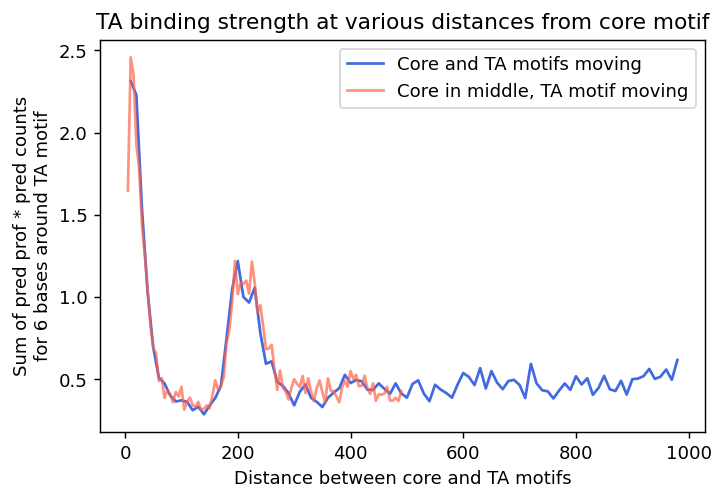

In [13]:
plot_TA_binding_strength_with_controls(TA_binding_strengths, TA_binding_strength_controls)

NameError: name 'all_avg_pred_profs_times_counts' is not defined

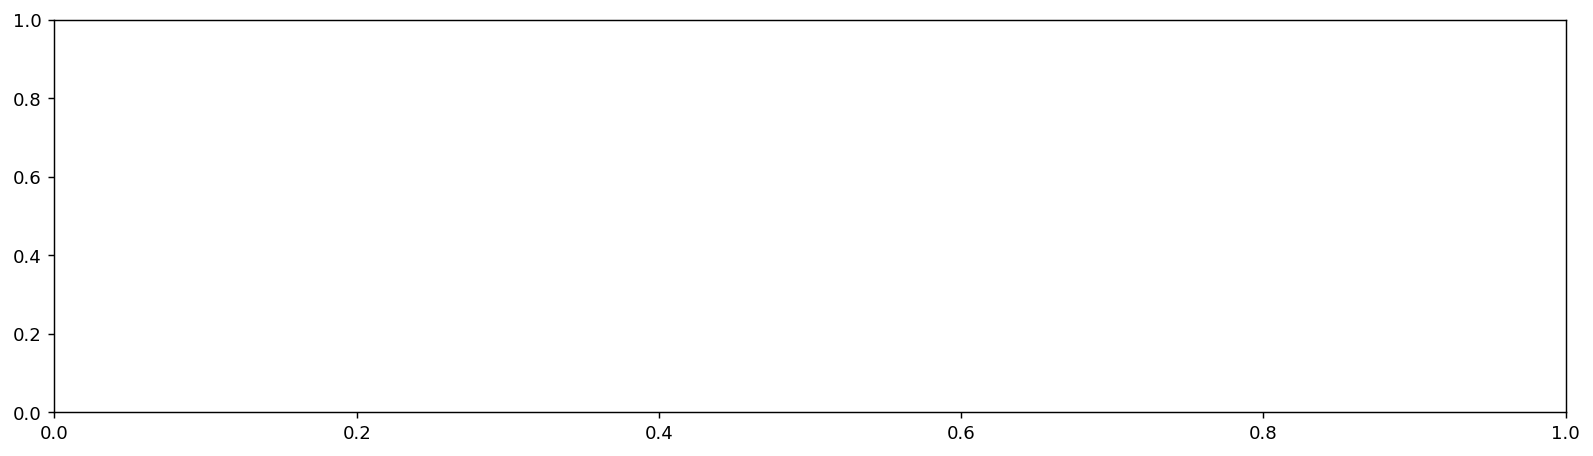

In [8]:
# new version, where profs are proportional to counts
fig, ax = plt.subplots(1, figsize=(15, 4))
upper_lim = np.max(list(np.max(all_avg_pred_profs_times_counts[i]) for i in range(100))) + 0.1  # so graphs look nice

def animate(i):
    plt.clf()
    
    pred_profs = all_avg_pred_profs_times_counts[i]
    
    ax.clear()
    plt.setp(ax, xlim=(0, 1000), ylim=(-upper_lim - 0.05, upper_lim + 0.05))

    ax.plot(pred_profs[0,:,0], color="royalblue")
    ax.plot(-pred_profs[0,:,1], color="goldenrod")
    
    title = ax.text(0.5,0.95, "", transform=ax.transAxes, ha="center")
    title.set_text('Distance between core and TA motifs: ' + str(i * 10))
    
def animate_with_core_no_TA(i):
    plt.clf()
    
    pred_profs = all_avg_pred_profs_times_counts[i]
    pred_profs_control = all_avg_pred_profs_times_counts_control[i]
    
    ax.clear()
    plt.setp(ax, xlim=(0, 1000), ylim=(-upper_lim - 0.05, upper_lim + 0.05))

    ax.plot(pred_profs[0,:,0], color="royalblue", label='Positive strand with TA motif')
    ax.plot(-pred_profs[0,:,1], color="goldenrod", label='Negative strand with TA motif')
    ax.plot(pred_profs_control[0,:,0], color="chartreuse", alpha=0.5, label='Positive strand without TA motif (control)')
    ax.plot(-pred_profs_control[0,:,1], color="tomato", alpha=0.5, label='Negative strand without TA motif (control)')
    ax.legend()
    
    title = ax.text(0.5,0.95, "", transform=ax.transAxes, ha="center")
    title.set_text('Distance between core and TA motifs: ' + str(i * 10))
    
def animate_with_static_core_moving_TA(i):
    plt.clf()
    
    pred_profs = all_avg_pred_profs_times_counts[i]
    pred_profs_control = all_avg_pred_profs_times_counts_control[i]
    
    ax.clear()
    plt.setp(ax, xlim=(0, 1000), ylim=(-upper_lim - 0.05, upper_lim + 0.05))

    ax.plot(pred_profs[0,:,0], color="royalblue", label='Positive strand with core and TA motifs moving')
    ax.plot(-pred_profs[0,:,1], color="goldenrod", label='Negative strand with core and TA motifs moving')
    ax.plot(pred_profs_control[0,:,0], color="chartreuse", alpha=0.7, label='Positive strand with ONLY TA motif moving')
    ax.plot(-pred_profs_control[0,:,1], color="tomato", alpha=0.7, label='Negative strand with ONLY TA motif moving')
    ax.legend()
    
    title = ax.text(0.5,0.95, "", transform=ax.transAxes, ha="center")
    title.set_text('Distance between moving core and TA motifs: ' + str(i * 10))

anim = FuncAnimation(fig, animate_with_static_core_moving_TA, frames=100)

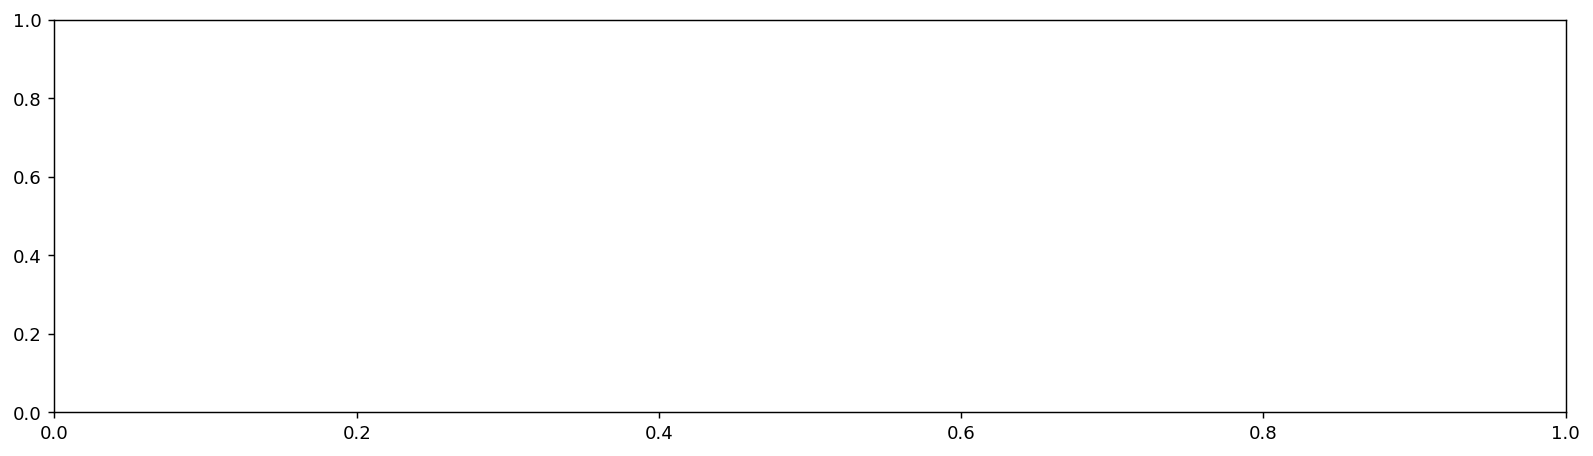

In [59]:
# old version, where profs and counts are split
fig, ax = plt.subplots(1, figsize=(15, 4))
upper_lim = np.max(list(np.max(all_avg_pred_profs[i] * all_avg_pred_counts[i]) for i in range(100))) + 0.1  # so graphs look nice

def animate(i):
    plt.clf()
    avg_pred_profs = all_avg_pred_profs[i]
    avg_pred_counts = all_avg_pred_counts[i]
    
    pred_profs = avg_pred_profs * avg_pred_counts
    
    ax.clear()
    plt.setp(ax, xlim=(0, 1000), ylim=(-upper_lim - 0.05, upper_lim + 0.05))

    ax.plot(pred_profs[0,:,0], color="royalblue")
    ax.plot(-pred_profs[0,:,1], color="goldenrod")
    
    title = ax.text(0.5,0.95, "", transform=ax.transAxes, ha="center")
    title.set_text('Distance between core and TA motifs: ' + str(i * 10))

anim = FuncAnimation(fig, animate, frames=100)

In [57]:
#anim.save('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_3/ctcf_cutnrun_static_core_moving_TA.mp4')

<Figure size 780x520 with 0 Axes>

In [15]:
HTML(anim.to_html5_video())

<Figure size 780x520 with 0 Axes>

## Core and TA motif interactions

For studying interactions between motifs at various distances, with Motif A at the center and Motif B downstream, at distance d between the motif edges. The average signal, PAB, for the TF that binds Motif A were then obtained using the trained BPNet model as oracle. Additional profiles were predicted by (1) inserting only Motif A in the center (PA), (2) inserting only Motif B d-bases downstream of the center (PB) and (3) not inserting any motif (PØ). The strand-specific summit (maximum) location of the footprint was then determined for each strand from profile PA within …  bp of the Motif A center. These summit locations were used to determine the average signal, h, within all four profiles to obtain hA, hB, hAB and hØ. The influence of Motif B on Motif A was then defined by the corrected binding fold change (hAB – (hB – hØ))/hA as a function of d.

In [7]:
def cooperative_preds_at_distance(distance, seqs, model):
    ''' given a distance between core motif and TA motif, along with 100 random background seqs
        and a model, insert motifs at appropriate distance in each seq, then calculate predictions 
        for each seq, then average predictions across all 100 seqs
        
        created jul 27:
        calculated cooperative binding of core and TA motifs
        [ p(AB) - (p(B) - p(null)) ] / p(A)    where A = core motif; B = TA motif

    '''
    core_insertion_index = 2114 // 2 - 10 #  - 10 can change to something else
    ta_insertion_index = core_insertion_index + len(core_motif) + distance
    
    original_seqs = seqs.copy()  # just to be careful with memory and overriding stuff
    AB_seqs = seqs.copy()
    A_seqs = seqs.copy()
    B_seqs = seqs.copy()
    # insert motifs 
    for i in range(len(original_seqs)):
        seq = original_seqs[i]
        assert seq.count(core_motif) < 5
        
        AB_seqs[i] = seq[:core_insertion_index] + core_motif + seq[core_insertion_index + len(core_motif):ta_insertion_index] + \
            ta_motif + seq[ta_insertion_index + len(ta_motif):]  # core motif in center, TA motif moving right
        
        A_seqs[i] = seq[:core_insertion_index] + core_motif + seq[core_insertion_index + len(core_motif):]  # only insert core motif
        
        B_seqs[i] = seq[:ta_insertion_index] + ta_motif + seq[ta_insertion_index + len(ta_motif):]  # only insert TA motif moving right

    seqs_dict = {'original':{'seqs':original_seqs}, 'AB':{'seqs':AB_seqs}, 'A':{'seqs':A_seqs}, 'B':{'seqs':B_seqs}}
    
    for key in seqs_dict.keys():    # get one-hot encoded seqs
        seqs_dict[key]['seqs'] = torch.from_numpy(dna_to_one_hot(seqs_dict[key]['seqs'])).float().cuda(device=device, non_blocking=True) 
    
    for key in seqs_dict.keys():
        seqs = seqs_dict[key]['seqs']
        
        # get predictions
        with torch.no_grad():
            if controls:
                cont_profs = torch.zeros((100, 1, 1000, 2)).cuda()  # CHANGE THIS IF MORE THAN 1 TASK, other issues etc.
                logit_pred_profs, log_pred_counts = model(seqs, cont_profs)
            else:
                logit_pred_profs, log_pred_counts = model(seqs)
        logit_pred_profs = logit_pred_profs.detach().cpu().numpy()  # go back to cpu
        log_pred_counts = log_pred_counts.detach().cpu().numpy()
        log_pred_profs = profile_logits_to_log_probs(logit_pred_profs)
    
        # average across all 100 seqs; THESE ARE ALREADY EXPONENTIATED, NO LOG!! also removes the 1st dimension!!
        avg_pred_profs = np.mean(np.exp(log_pred_profs), axis=0) 
        avg_pred_counts = np.mean(np.exp(log_pred_counts), axis=0) 

        log_pred_counts_reshaped = np.repeat(log_pred_counts[:, :, np.newaxis, :], 1000, axis=2)  # same shape as log_pred_profs now
        avg_pred_profs_times_counts = np.mean(np.exp(log_pred_profs) * np.exp(log_pred_counts_reshaped), axis=0) 
        
        seqs_dict[key]['avg_profs'] = avg_pred_profs_times_counts

    
    cooperative_preds = (seqs_dict['AB']['avg_profs'] - (seqs_dict['B']['avg_profs'] - seqs_dict['original']['avg_profs']) ) / \
                                                        seqs_dict['A']['avg_profs']   # shape 1 x 1000 x 2
    # calculate TA binding strength per strand, so it's (2,) shape 
    # print(ta_insertion_index - (2114//2-500) - 3)
    # print(ta_insertion_index - (2114//2-500) + 3)
    # print()
    TA_binding_strength = np.sum(cooperative_preds[0][ta_insertion_index - (2114//2-500) - 3 : ta_insertion_index - (2114//2-500) + 3], axis=0)
    
    # calculate core motif binding strength per strand, so it's (2,) shape 
    # print(core_insertion_index - (2114//2-500) - 3)
    # print(core_insertion_index - (2114//2-500) + 3)
    # print('\n\n')
    core_binding_strength = np.sum(cooperative_preds[0][core_insertion_index - (2114//2-500) -3 : core_insertion_index - (2114//2-500) + 3], axis=0)
            
    return cooperative_preds, TA_binding_strength, core_binding_strength, seqs_dict

In [8]:
def plot_core_binding_strength(core_binding_strengths):
    ''' core_binding_strengths is a list of length 100 from running cooperative_preds_at_distance over 100 distances (100 times) ''' 
    # plot core binding strength as TA moves right, away from core motif by some distance
    plt.plot(list(range(10,490,10)), list(np.mean((i[0], i[1])) for i in core_binding_strengths[1:-1]), color='royalblue')
    plt.xlabel('Distance between core and TA motifs')
    plt.ylabel('Sum of pred prof * pred counts\nfor 6 bases around core motif')
    plt.title('Core motif binding strength as TA motif moves right')
    plt.show() 
    
def plot_TA_binding_strength(TA_binding_strengths):    # EXACT SAME FUNC AS WAY ABOVE just put here again for ease of access
    ''' TA_binding_strengths is a list of length 100 from running avg_preds_at_distance over 100 distances (100 times) ''' 
    # plot TA binding strength at each distance from core motif
    plt.plot(list(range(10,490,10)), list(np.mean((i[0], i[1])) for i in TA_binding_strengths[1:-1]), color='royalblue')
    # plt.plot(list(range(10,490,10)), list(i[0] for i in TA_binding_strengths[1:-1]), color='royalblue')
    plt.xlabel('Distance between core and TA motifs')
    plt.ylabel('Sum of pred prof * pred counts\nfor 6 bases around TA motif')
    plt.title('TA binding strength at various distances from core motif')
    plt.show() 
    
def plot_strengths(core_binding_strengths, TA_binding_strengths):
    ''' plot both TA and core motif binding strengths, overlaid onto one (1) plot hehe '''
    plt.plot(list(range(10,490,10)), list(np.mean((i[0], i[1])) for i in core_binding_strengths[1:-1]), color='royalblue', 
             label='Core motif binding strength')
    plt.plot(list(range(10,490,10)), list(np.mean((i[0], i[1])) for i in TA_binding_strengths[1:-1]), color='maroon',
            label='TA motif binding strength')
    plt.xlabel('Distance between core and TA motifs')
    plt.ylabel('Sum of pred prof * pred counts\nfor 6 bases around motif')
    plt.title('Core and TA motifs binding strength as TA motif moves right')
    plt.legend()
    plt.show() 

In [9]:
all_avg_pred_profs_times_counts, TA_binding_strengths, core_binding_strengths, seqs_dicts = [], [], [], []
for distance in range(0,500,10):
    avg_pred_profs_times_counts, TA_binding_strength, core_binding_strength, seqs_dict = cooperative_preds_at_distance(distance, seqs, model)
    all_avg_pred_profs_times_counts.append(avg_pred_profs_times_counts)
    TA_binding_strengths.append(TA_binding_strength)
    core_binding_strengths.append(core_binding_strength)
    seqs_dicts.append(seqs_dict)

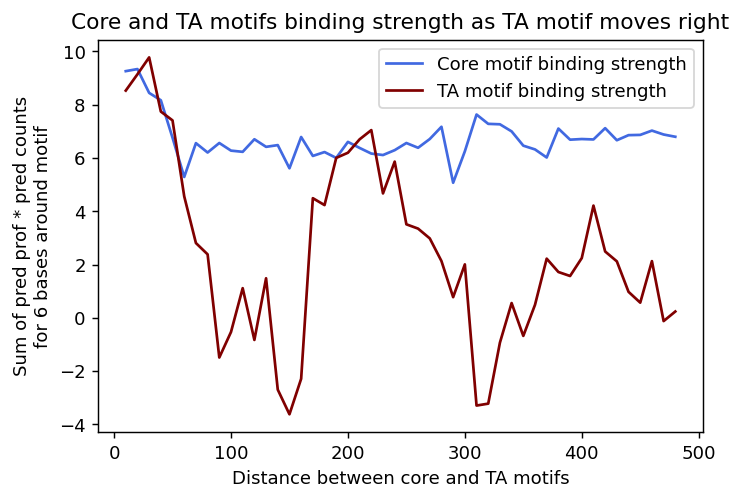

In [10]:
plot_strengths(core_binding_strengths, TA_binding_strengths)

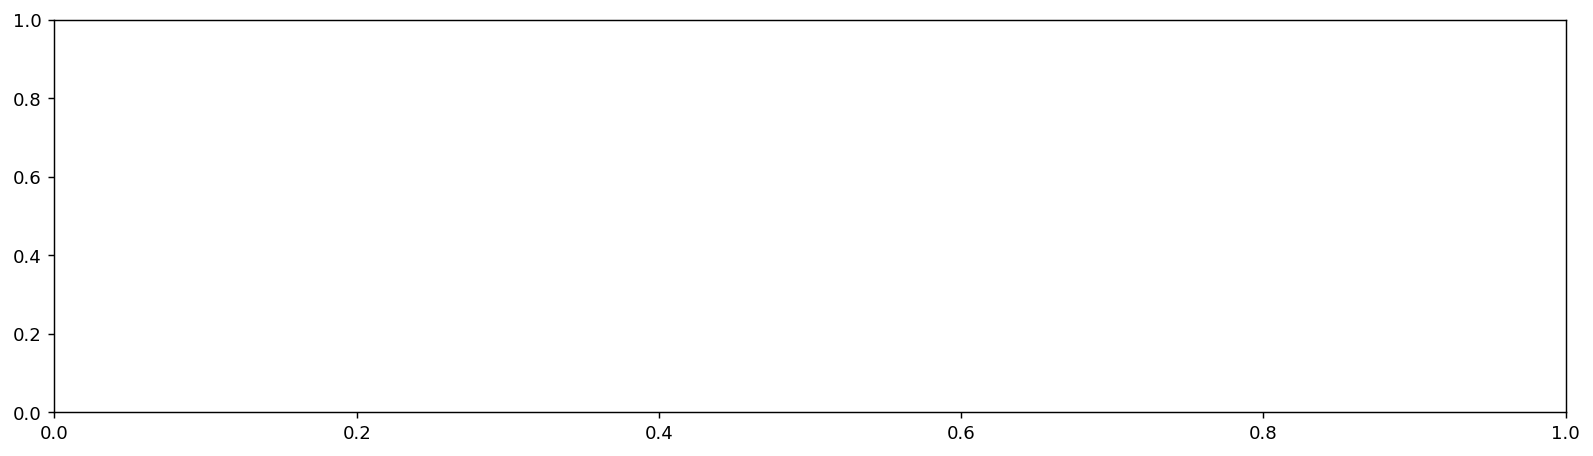

In [11]:
# new version, where profs are proportional to counts
fig, ax = plt.subplots(1, figsize=(15, 4))
# upper_lim = np.max(list(np.max(all_avg_pred_profs_times_counts[i]) for i in range(1,49))) + 0.01  # so graphs look nice
upper_lim = np.max(list(np.max(seqs_dicts[i]['AB']['avg_profs']) for i in range(1,49))) + 0.01  # so graphs look nice

def animate(i):
    plt.clf()
    
    pred_profs = all_avg_pred_profs_times_counts[i]
    
    ax.clear()
    plt.setp(ax, xlim=(0, 1000), ylim=(-upper_lim - 0.05, upper_lim + 0.05))

    ax.plot(np.abs(pred_profs[0,:,0]), color="royalblue")
    ax.plot(-np.abs(pred_profs[0,:,1]), color="goldenrod")
    
    
    # highlight the TA location
    # ta_insertion_index = 2114 // 2 + 1 + i * 10  # distance = i * 10 here
    # ax.plot([ta_insertion_index - (2114//2-500) - 1, ta_insertion_index - (2114//2-500)], pred_profs[0,ta_insertion_index - (2114//2-500) - 1 : ta_insertion_index - (2114//2-500) + 1,0], color="maroon") 
    
    title = ax.text(0.5,0.95, "", transform=ax.transAxes, ha="center")
    title.set_text('Distance between core and TA motifs: ' + str(i * 10))
    
    
def animate_pieces(i):
    plt.clf()
    
    pred_profs = seqs_dicts[i]
    
    ax.clear()
    plt.setp(ax, xlim=(0, 1000), ylim=(-upper_lim - 0.05, upper_lim + 0.05))

    ax.plot(np.abs(pred_profs['AB']['avg_profs'][0,:,0]), color="magenta", alpha=0.9, label='AB')
    ax.plot(-np.abs(pred_profs['AB']['avg_profs'][0,:,1]), color="magenta", alpha=0.9)
    
    ax.plot(np.abs(pred_profs['A']['avg_profs'][0,:,0]), color="cornflowerblue", alpha=0.7, label='A')
    ax.plot(-np.abs(pred_profs['A']['avg_profs'][0,:,1]), color="cornflowerblue", alpha=0.7)
    
    ax.plot(np.abs(pred_profs['B']['avg_profs'][0,:,0]), color="maroon", alpha=0.7, label='B')
    ax.plot(-np.abs(pred_profs['B']['avg_profs'][0,:,1]), color="maroon", alpha=0.7)
    
    ax.plot(np.abs(pred_profs['original']['avg_profs'][0,:,0]), color="chartreuse", alpha=0.5, label='null')
    ax.plot(-np.abs(pred_profs['original']['avg_profs'][0,:,1]), color="chartreuse", alpha=0.5)
    
    title = ax.text(0.5,0.95, "", transform=ax.transAxes, ha="center")
    title.set_text('Distance between core and TA motifs: ' + str(i * 10))
    
    ax.legend()

anim = FuncAnimation(fig, animate_pieces, frames=50)

In [13]:
# anim.save('/home/katie/bp_repo/reports/katie_notebooks/round2_tasks_mar2022/TASK_3/ctcf_cutnrun_pieces.mp4')

<Figure size 780x520 with 0 Axes>

In [12]:
HTML(anim.to_html5_video())

<Figure size 780x520 with 0 Axes>

## testing in increments

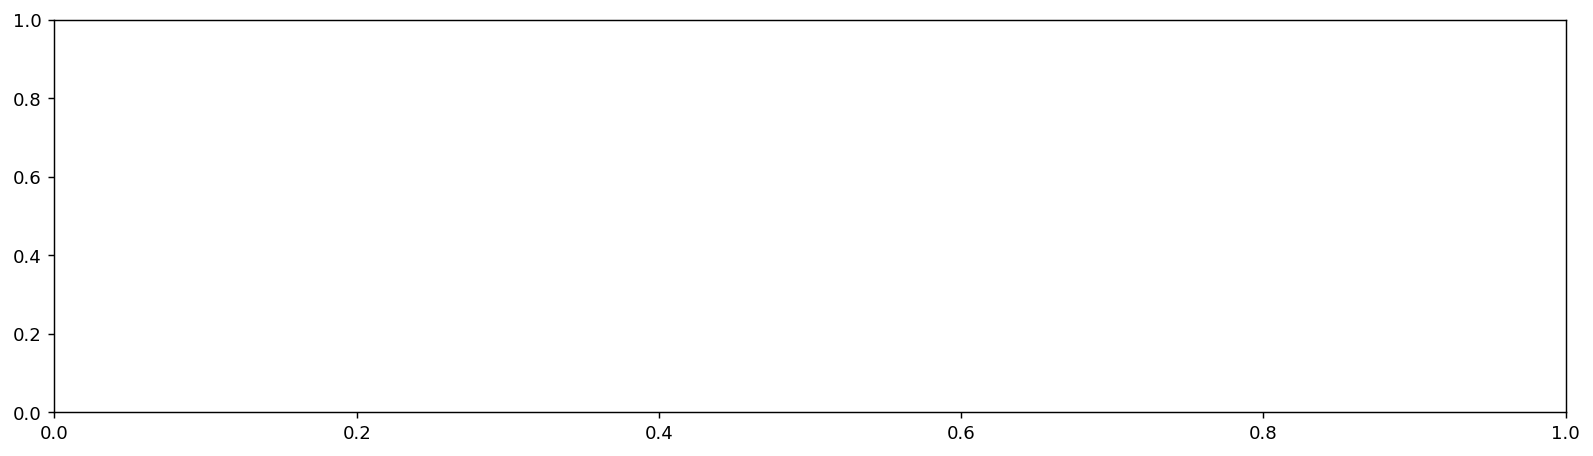

In [105]:
# testing original, AB, A, and B
fig, ax = plt.subplots(1, figsize=(15, 4))
upper_lim = np.max(list(np.max((seqs_dicts[i]['AB']['avg_profs'] - (seqs_dicts[i]['B']['avg_profs'] - seqs_dicts[i]['original']['avg_profs'])) \
                               / seqs_dicts[i]['A']['avg_profs']) \
                        for i in range(1,50))) + 0.1  # so graphs look nice

def animate(i):
    plt.clf()
    
    pred_profs = (seqs_dicts[i]['AB']['avg_profs'] - (seqs_dicts[i]['B']['avg_profs'] - seqs_dicts[i]['original']['avg_profs'])) \
                   / seqs_dicts[i]['A']['avg_profs']
    
    ax.clear()
    plt.setp(ax, xlim=(0, 1000), ylim=(-upper_lim - 0.05, upper_lim + 0.05))

    ax.plot(pred_profs[0,:,0], color="royalblue")
    ax.plot(-pred_profs[0,:,1], color="goldenrod")
    
    title = ax.text(0.5,0.95, "", transform=ax.transAxes, ha="center")
    title.set_text('Distance between core and TA motifs: ' + str(i * 10))

anim = FuncAnimation(fig, animate, frames=50)

In [106]:
# AB - (B - original)     / A
HTML(anim.to_html5_video())

<Figure size 780x520 with 0 Axes>

In [100]:
# AB - (B - original)
HTML(anim.to_html5_video())

<Figure size 780x520 with 0 Axes>

In [96]:
# B - original
HTML(anim.to_html5_video())

<Figure size 780x520 with 0 Axes>

## testing original, AB, A, and B independently

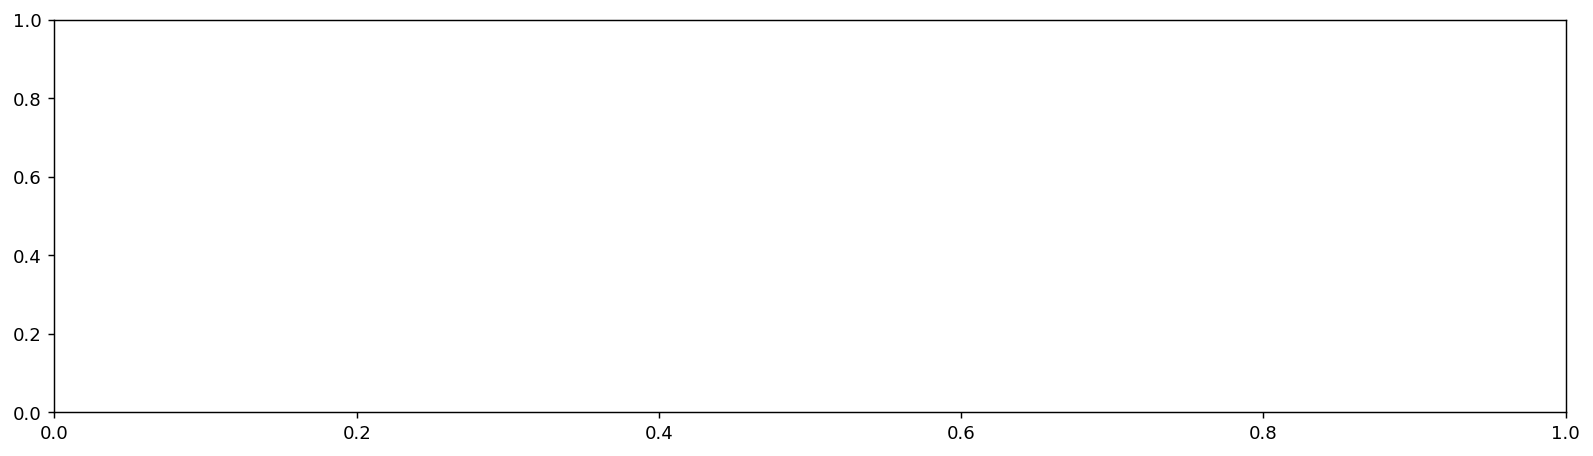

In [93]:
# testing original, AB, A, and B
motifs_type = 'AB'

fig, ax = plt.subplots(1, figsize=(15, 4))
upper_lim = np.max(list(np.max(seqs_dicts[i][motifs_type]['avg_profs']) for i in range(50))) + 0.1  # so graphs look nice

def animate(i):
    plt.clf()
    
    pred_profs = seqs_dicts[i][motifs_type]['avg_profs']
    
    ax.clear()
    plt.setp(ax, xlim=(0, 1000), ylim=(-upper_lim - 0.05, upper_lim + 0.05))

    ax.plot(pred_profs[0,:,0], color="royalblue")
    ax.plot(-pred_profs[0,:,1], color="goldenrod")
    
    title = ax.text(0.5,0.95, "", transform=ax.transAxes, ha="center")
    title.set_text('Distance between core and TA motifs: ' + str(i * 10))

anim = FuncAnimation(fig, animate, frames=50)

In [94]:
# AB
HTML(anim.to_html5_video())

<Figure size 780x520 with 0 Axes>

In [92]:
# B
HTML(anim.to_html5_video())

<Figure size 780x520 with 0 Axes>

In [90]:
# A
HTML(anim.to_html5_video())

<Figure size 780x520 with 0 Axes>

### e) How do the total counts change as the distance changes?
would need to rewrite this bc doesn't work now that i took out all_avg_pred_counts :/

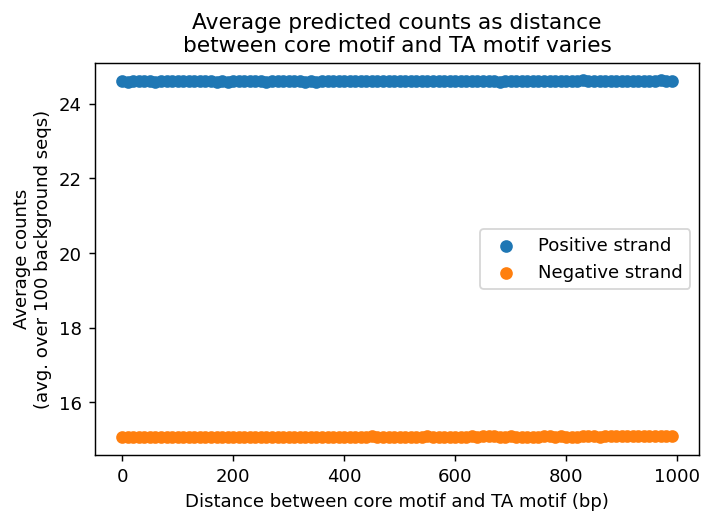

In [65]:
fig, ax = plt.subplots()
ax.scatter(list(i * 10 for i in range(100)), list(i[0][0] for i in all_avg_pred_counts), label='Positive strand')
ax.scatter(list(i * 10 for i in range(100)), list(i[0][1] for i in all_avg_pred_counts), label='Negative strand')

plt.xlabel('Distance between core motif and TA motif (bp)')
plt.ylabel('Average counts\n(avg. over 100 background seqs)')
plt.title('Average predicted counts as distance\nbetween core motif and TA motif varies')

ax.legend()